In [11]:
import pickle
import numpy as np
from skimage import io
import random
import pandas as pd
import torch
import copy

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
SEED = 69

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=12
BATCH_SIZE=64

In [3]:
class SimpsonsDataset(Dataset):
  def __init__(self, files, mode, augmentations = None):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations

    if self.mode not in DATA_MODES:
      print(f'wrong mode: {self.mode}')
      raise NameError

    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    transform_list = []
    transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
    if self.mode != 'test':            
        transform_list.append(transforms.RandomHorizontalFlip())
        transform_list.append(transforms.RandomRotation(15))
    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

    transform = transforms.Compose(transform_list)
    x = self.load_sample(self.files[index])
    x = transform(x)
    if self.mode == 'test':
        return x
    else:
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]

train_files = train_val_files.copy()
train_dataset = SimpsonsDataset(train_files, mode='train')

20933
21887


In [7]:
class MyCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 256, 512),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        self.out = nn.Linear(512, n_classes) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 128)
        x = self.fc1(x)
        logits = self.out(x)
        return logits

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:       
        opt = torch.optim.Adam(model.parameters())
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #    opt, mode='max', factor=0.1, patience=10, verbose=False)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)        
        criterion = nn.CrossEntropyLoss()
        best_acc = 0.0

        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            #scheduler.step(val_acc)
            scheduler.step()
            
            if val_acc > best_acc:
                best_model_wghts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wghts, './model/simplecnn.mdl')
                best_acc = val_acc
            
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


FOLD 1


epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]

loss 1.8897979594194758


epoch:   8%|██████▎                                                                     | 1/12 [01:08<12:28, 68.08s/it]


Epoch 001 train_loss: 1.8898     val_loss 1.3390 train_acc 0.4911 val_acc 0.6265
loss 1.1264550642716946


epoch:  17%|████████████▋                                                               | 2/12 [02:13<11:11, 67.19s/it]


Epoch 002 train_loss: 1.1265     val_loss 0.9569 train_acc 0.6812 val_acc 0.7302
loss 0.7292391604042467


epoch:  25%|███████████████████                                                         | 3/12 [03:18<09:59, 66.58s/it]


Epoch 003 train_loss: 0.7292     val_loss 0.7402 train_acc 0.7959 val_acc 0.7933
loss 0.515088005094922


epoch:  33%|█████████████████████████▎                                                  | 4/12 [04:22<08:45, 65.72s/it]


Epoch 004 train_loss: 0.5151     val_loss 0.6722 train_acc 0.8514 val_acc 0.8200
loss 0.39905783681963736


epoch:  42%|███████████████████████████████▋                                            | 5/12 [05:26<07:37, 65.42s/it]


Epoch 005 train_loss: 0.3991     val_loss 0.6632 train_acc 0.8854 val_acc 0.8237
loss 0.32709693336780943


epoch:  50%|██████████████████████████████████████                                      | 6/12 [06:33<06:34, 65.81s/it]


Epoch 006 train_loss: 0.3271     val_loss 0.6338 train_acc 0.9014 val_acc 0.8355
loss 0.27459065692470663


epoch:  58%|████████████████████████████████████████████▎                               | 7/12 [07:40<05:30, 66.08s/it]


Epoch 007 train_loss: 0.2746     val_loss 0.6020 train_acc 0.9175 val_acc 0.8506
loss 0.21982343742634883


epoch:  67%|██████████████████████████████████████████████████▋                         | 8/12 [08:46<04:25, 66.28s/it]


Epoch 008 train_loss: 0.2198     val_loss 0.5968 train_acc 0.9327 val_acc 0.8506
loss 0.1932781800475369


epoch:  75%|█████████████████████████████████████████████████████████                   | 9/12 [09:53<03:19, 66.37s/it]


Epoch 009 train_loss: 0.1933     val_loss 0.6582 train_acc 0.9433 val_acc 0.8536
loss 0.17107299063923875


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 10/12 [11:01<02:13, 66.92s/it]


Epoch 010 train_loss: 0.1711     val_loss 0.6505 train_acc 0.9500 val_acc 0.8538
loss 0.15807522719858838


epoch:  92%|████████████████████████████████████████████████████████████████████▊      | 11/12 [12:06<01:06, 66.15s/it]


Epoch 011 train_loss: 0.1581     val_loss 0.6559 train_acc 0.9516 val_acc 0.8611
loss 0.13803999865951758


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 12/12 [13:09<00:00, 65.79s/it]


Epoch 012 train_loss: 0.1380     val_loss 0.6923 train_acc 0.9584 val_acc 0.8620


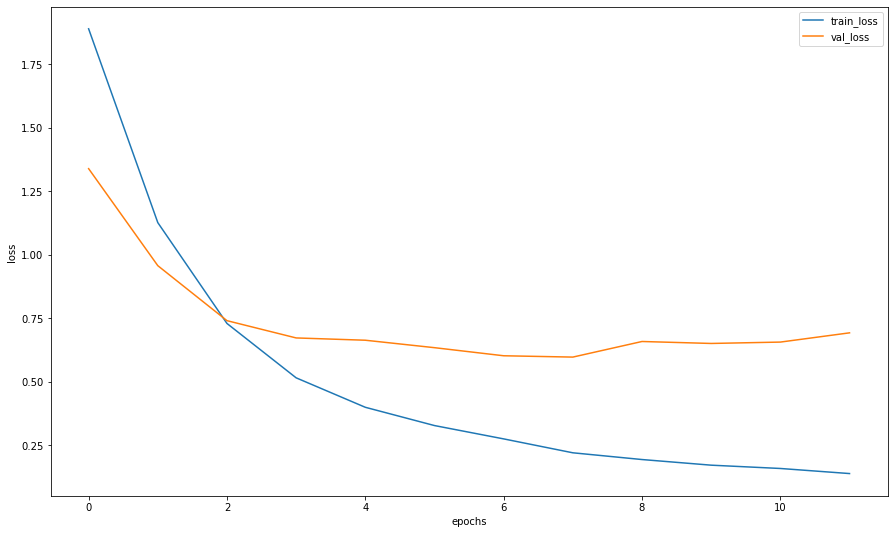

epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]


FOLD 2
loss 1.883007351631399


epoch:   8%|██████▎                                                                     | 1/12 [01:03<11:34, 63.11s/it]


Epoch 001 train_loss: 1.8830     val_loss 1.3538 train_acc 0.4973 val_acc 0.6213
loss 1.0854723870812113


epoch:  17%|████████████▋                                                               | 2/12 [02:06<10:32, 63.23s/it]


Epoch 002 train_loss: 1.0855     val_loss 0.8635 train_acc 0.6966 val_acc 0.7682
loss 0.714776861173339


epoch:  25%|███████████████████                                                         | 3/12 [03:11<09:32, 63.58s/it]


Epoch 003 train_loss: 0.7148     val_loss 0.7116 train_acc 0.7958 val_acc 0.8074
loss 0.5035591471187731


epoch:  33%|█████████████████████████▎                                                  | 4/12 [04:17<08:35, 64.47s/it]


Epoch 004 train_loss: 0.5036     val_loss 0.6702 train_acc 0.8528 val_acc 0.8287
loss 0.39254336137986484


epoch:  42%|███████████████████████████████▋                                            | 5/12 [05:25<07:37, 65.42s/it]


Epoch 005 train_loss: 0.3925     val_loss 0.6480 train_acc 0.8836 val_acc 0.8335
loss 0.3080102317658598


epoch:  50%|██████████████████████████████████████                                      | 6/12 [06:30<06:31, 65.24s/it]


Epoch 006 train_loss: 0.3080     val_loss 0.5996 train_acc 0.9074 val_acc 0.8529
loss 0.24892989782782132


epoch:  58%|████████████████████████████████████████████▎                               | 7/12 [07:34<05:25, 65.01s/it]


Epoch 007 train_loss: 0.2489     val_loss 0.6355 train_acc 0.9280 val_acc 0.8531
loss 0.2170146273578743


epoch:  67%|██████████████████████████████████████████████████▋                         | 8/12 [08:39<04:19, 64.88s/it]


Epoch 008 train_loss: 0.2170     val_loss 0.6399 train_acc 0.9337 val_acc 0.8545
loss 0.18910988658671718


epoch:  75%|█████████████████████████████████████████████████████████                   | 9/12 [09:43<03:14, 64.76s/it]


Epoch 009 train_loss: 0.1891     val_loss 0.6574 train_acc 0.9423 val_acc 0.8650
loss 0.1658067927994266


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 10/12 [10:48<02:09, 64.79s/it]


Epoch 010 train_loss: 0.1658     val_loss 0.6987 train_acc 0.9492 val_acc 0.8531
loss 0.1477308913574301


epoch:  92%|████████████████████████████████████████████████████████████████████▊      | 11/12 [11:53<01:04, 64.74s/it]


Epoch 011 train_loss: 0.1477     val_loss 0.6992 train_acc 0.9535 val_acc 0.8655
loss 0.15969387036387328


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 12/12 [12:58<00:00, 64.85s/it]


Epoch 012 train_loss: 0.1597     val_loss 0.7630 train_acc 0.9539 val_acc 0.8552


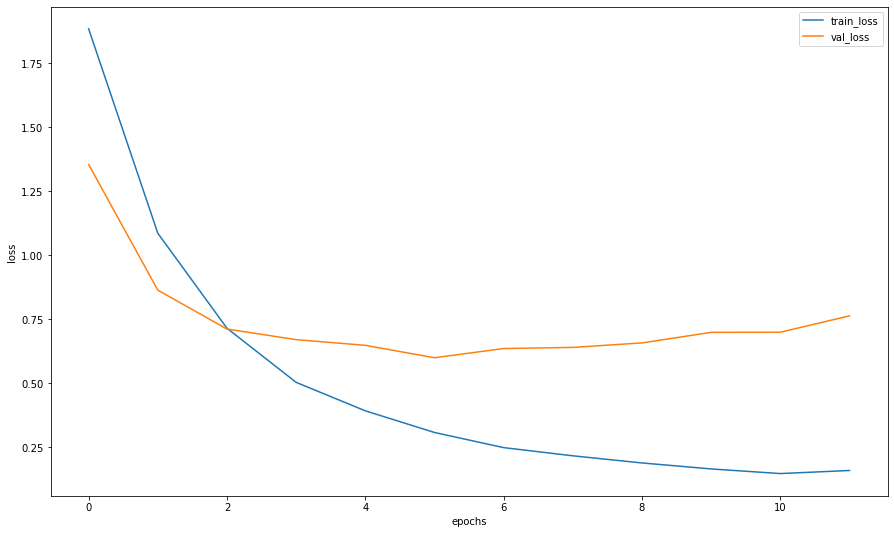

epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]


FOLD 3
loss 1.9246078220522111


epoch:   8%|██████▎                                                                     | 1/12 [01:04<11:54, 64.91s/it]


Epoch 001 train_loss: 1.9246     val_loss 1.4074 train_acc 0.4798 val_acc 0.6077
loss 1.123097960190525


epoch:  17%|████████████▋                                                               | 2/12 [02:10<10:50, 65.03s/it]


Epoch 002 train_loss: 1.1231     val_loss 0.8787 train_acc 0.6864 val_acc 0.7587
loss 0.7176651505999126


epoch:  25%|███████████████████                                                         | 3/12 [03:14<09:44, 64.94s/it]


Epoch 003 train_loss: 0.7177     val_loss 0.7574 train_acc 0.7974 val_acc 0.7953
loss 0.5156678476754357


epoch:  33%|█████████████████████████▎                                                  | 4/12 [04:24<08:50, 66.33s/it]


Epoch 004 train_loss: 0.5157     val_loss 0.6571 train_acc 0.8491 val_acc 0.8204
loss 0.39942179841358005


epoch:  42%|███████████████████████████████▋                                            | 5/12 [05:32<07:48, 66.97s/it]


Epoch 005 train_loss: 0.3994     val_loss 0.6155 train_acc 0.8845 val_acc 0.8398
loss 0.31704421374608555


epoch:  50%|██████████████████████████████████████                                      | 6/12 [06:39<06:40, 66.81s/it]


Epoch 006 train_loss: 0.3170     val_loss 0.6214 train_acc 0.9061 val_acc 0.8501
loss 0.24507928176446345


epoch:  58%|████████████████████████████████████████████▎                               | 7/12 [07:47<05:35, 67.15s/it]


Epoch 007 train_loss: 0.2451     val_loss 0.6780 train_acc 0.9259 val_acc 0.8526
loss 0.22443972951612903


epoch:  67%|██████████████████████████████████████████████████▋                         | 8/12 [08:53<04:27, 66.93s/it]


Epoch 008 train_loss: 0.2244     val_loss 0.6497 train_acc 0.9308 val_acc 0.8499
loss 0.1899654502803295


epoch:  75%|█████████████████████████████████████████████████████████                   | 9/12 [10:01<03:21, 67.14s/it]


Epoch 009 train_loss: 0.1900     val_loss 0.6460 train_acc 0.9411 val_acc 0.8599
loss 0.16038630908660417


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 10/12 [11:09<02:14, 67.33s/it]


Epoch 010 train_loss: 0.1604     val_loss 0.6211 train_acc 0.9507 val_acc 0.8771
loss 0.14570481433085822


epoch:  92%|████████████████████████████████████████████████████████████████████▊      | 11/12 [12:16<01:07, 67.18s/it]


Epoch 011 train_loss: 0.1457     val_loss 0.6751 train_acc 0.9540 val_acc 0.8620
loss 0.14933900230871072


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 12/12 [13:22<00:00, 66.85s/it]


Epoch 012 train_loss: 0.1493     val_loss 0.6591 train_acc 0.9551 val_acc 0.8604


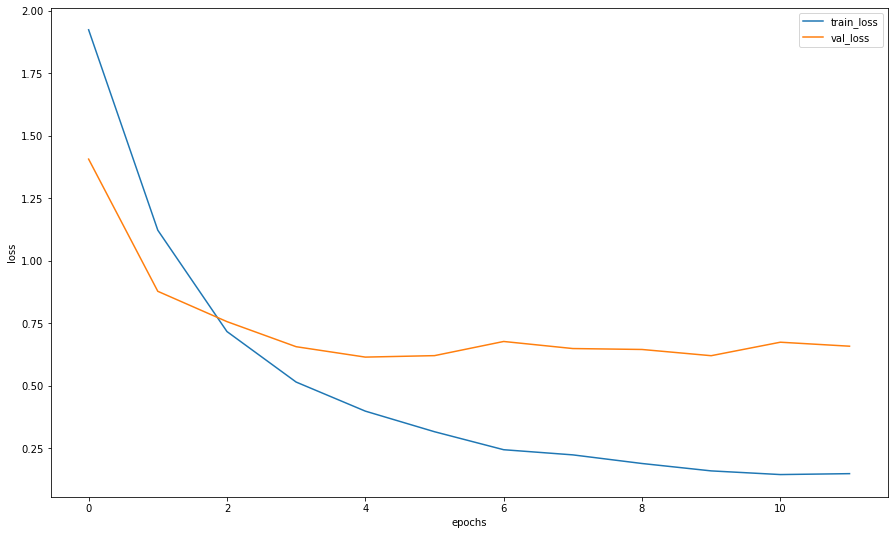

epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]


FOLD 4
loss 1.8704300708868788


epoch:   8%|██████▎                                                                     | 1/12 [01:04<11:44, 64.07s/it]


Epoch 001 train_loss: 1.8704     val_loss 1.3667 train_acc 0.4970 val_acc 0.6043
loss 1.0555363367789816


epoch:  17%|████████████▋                                                               | 2/12 [02:11<10:50, 65.09s/it]


Epoch 002 train_loss: 1.0555     val_loss 1.0045 train_acc 0.7050 val_acc 0.7126
loss 0.6595644552050013


epoch:  25%|███████████████████                                                         | 3/12 [03:18<09:52, 65.79s/it]


Epoch 003 train_loss: 0.6596     val_loss 0.7765 train_acc 0.8137 val_acc 0.7809
loss 0.48068209522319205


epoch:  33%|█████████████████████████▎                                                  | 4/12 [04:27<08:53, 66.73s/it]


Epoch 004 train_loss: 0.4807     val_loss 0.7164 train_acc 0.8626 val_acc 0.8074
loss 0.37862955030885714


epoch:  42%|███████████████████████████████▋                                            | 5/12 [05:36<07:50, 67.15s/it]


Epoch 005 train_loss: 0.3786     val_loss 0.6113 train_acc 0.8910 val_acc 0.8355
loss 0.2804546102294236


epoch:  50%|██████████████████████████████████████                                      | 6/12 [06:43<06:43, 67.31s/it]


Epoch 006 train_loss: 0.2805     val_loss 0.6250 train_acc 0.9156 val_acc 0.8478
loss 0.2405822817085131


epoch:  58%|████████████████████████████████████████████▎                               | 7/12 [07:49<05:34, 66.86s/it]


Epoch 007 train_loss: 0.2406     val_loss 0.6103 train_acc 0.9284 val_acc 0.8488
loss 0.207471887381808


epoch:  67%|██████████████████████████████████████████████████▋                         | 8/12 [08:56<04:27, 66.79s/it]


Epoch 008 train_loss: 0.2075     val_loss 0.5620 train_acc 0.9379 val_acc 0.8629
loss 0.18977606812931347


epoch:  75%|█████████████████████████████████████████████████████████                   | 9/12 [10:02<03:19, 66.60s/it]


Epoch 009 train_loss: 0.1898     val_loss 0.6823 train_acc 0.9432 val_acc 0.8426
loss 0.1596742362052049


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 10/12 [11:06<02:11, 65.86s/it]


Epoch 010 train_loss: 0.1597     val_loss 0.6530 train_acc 0.9520 val_acc 0.8561
loss 0.1455830160241206


epoch:  92%|████████████████████████████████████████████████████████████████████▊      | 11/12 [12:13<01:06, 66.10s/it]


Epoch 011 train_loss: 0.1456     val_loss 0.6437 train_acc 0.9568 val_acc 0.8542
loss 0.13733453737079315


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 12/12 [13:21<00:00, 66.82s/it]


Epoch 012 train_loss: 0.1373     val_loss 0.6345 train_acc 0.9581 val_acc 0.8611


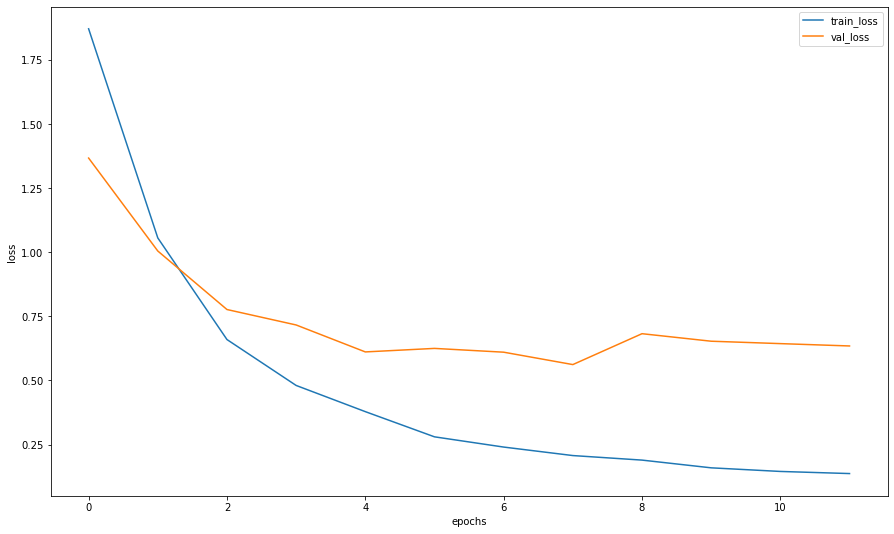

epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]


FOLD 5
loss 1.943336130032738


epoch:   8%|██████▎                                                                     | 1/12 [01:10<12:52, 70.27s/it]


Epoch 001 train_loss: 1.9433     val_loss 1.4616 train_acc 0.4721 val_acc 0.5901
loss 1.0980291054086777


epoch:  17%|████████████▋                                                               | 2/12 [02:16<11:30, 69.07s/it]


Epoch 002 train_loss: 1.0980     val_loss 0.8976 train_acc 0.6939 val_acc 0.7510
loss 0.7044856818657749


epoch:  25%|███████████████████                                                         | 3/12 [03:25<10:20, 69.00s/it]


Epoch 003 train_loss: 0.7045     val_loss 0.7412 train_acc 0.8010 val_acc 0.7930
loss 0.5044806808624726


epoch:  33%|█████████████████████████▎                                                  | 4/12 [04:31<09:04, 68.04s/it]


Epoch 004 train_loss: 0.5045     val_loss 0.6280 train_acc 0.8549 val_acc 0.8309
loss 0.3916916635327854


epoch:  42%|███████████████████████████████▋                                            | 5/12 [05:36<07:51, 67.29s/it]


Epoch 005 train_loss: 0.3917     val_loss 0.6330 train_acc 0.8852 val_acc 0.8325
loss 0.303552966639357


epoch:  50%|██████████████████████████████████████                                      | 6/12 [06:41<06:39, 66.54s/it]


Epoch 006 train_loss: 0.3036     val_loss 0.6388 train_acc 0.9095 val_acc 0.8531
loss 0.2601928674956855


epoch:  58%|████████████████████████████████████████████▎                               | 7/12 [07:46<05:30, 66.10s/it]


Epoch 007 train_loss: 0.2602     val_loss 0.6682 train_acc 0.9236 val_acc 0.8376
loss 0.22050374328732694


epoch:  67%|██████████████████████████████████████████████████▋                         | 8/12 [08:54<04:26, 66.65s/it]


Epoch 008 train_loss: 0.2205     val_loss 0.6039 train_acc 0.9344 val_acc 0.8631
loss 0.19687446668480274


epoch:  75%|█████████████████████████████████████████████████████████                   | 9/12 [10:05<03:23, 67.94s/it]


Epoch 009 train_loss: 0.1969     val_loss 0.6468 train_acc 0.9407 val_acc 0.8490
loss 0.1589484334843013


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 10/12 [11:14<02:16, 68.41s/it]


Epoch 010 train_loss: 0.1589     val_loss 0.6734 train_acc 0.9515 val_acc 0.8606
loss 0.15484432401247258


epoch:  92%|████████████████████████████████████████████████████████████████████▊      | 11/12 [12:24<01:08, 68.81s/it]


Epoch 011 train_loss: 0.1548     val_loss 0.6725 train_acc 0.9543 val_acc 0.8494
loss 0.12787964933263038


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 12/12 [13:33<00:00, 67.83s/it]


Epoch 012 train_loss: 0.1279     val_loss 0.7271 train_acc 0.9611 val_acc 0.8643


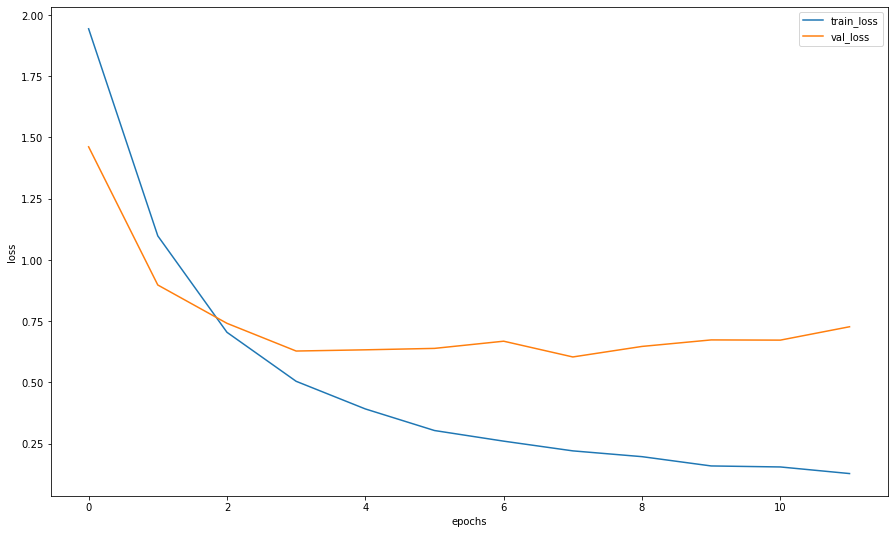

In [9]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
submit = pd.DataFrame(columns=['Id'])

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
n_classes = len(np.unique(train_val_labels))

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    model = MyCnn(n_classes).to(DEVICE)
    history = train(train_dataset, val_dataset, model=model, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    
    submit[f'fold_{fold+1}'] = preds

In [16]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

#model = MyCnn(n_classes).to(DEVICE)
model.load_state_dict(torch.load('./model/simplecnn.mdl'))
model.eval()

random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = train_dataset[random_characters]
probs_im = predict_one_sample(test_model, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)
actual_labels = [train_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_labels, y_pred, average='weighted')

0.25263157894736843

In [17]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit.head(50)

,Id,fold_1,fold_2,fold_3,fold_4,fold_5,Expected
0,img0.jpg,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz
1,img1.jpg,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders
3,img100.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman
6,img103.jpg,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel,edna_krabappel
7,img104.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
8,img105.jpg,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson,lisa_simpson
9,img106.jpg,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman,kent_brockman


In [18]:
submit['Expected'] = submit.mode(axis=1)[0]
submit.head()

,Id,fold_1,fold_2,fold_3,fold_4,fold_5,Expected
0,img0.jpg,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz
1,img1.jpg,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders,ned_flanders
3,img100.jpg,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon


In [19]:
submit[['Id', 'Expected']].to_csv('./out/simple_kf_lrplateau.csv', index=False)